# Lien entre les polygones de DVF et l'adresse

DVF met à la disposition des utilisateurs un fichier disposition contenant des polygones représentant les parcelles impactées par une mutation. Le problème est que nous ne disposons pas de l'adresse (ou au moins d'une adresse) associée à cette passerelle. L'idée est donc d'utiliser les données cadastrales disponibles [ici](https://cadastre.data.gouv.fr/datasets/cadastre-etalab) afin d'obtenir une première approximation de l'adresse.

Ici, nous cherchons à vérifier s'il est possible de mobiliser uniquement les fichers cadastraux à l'échelle de la section plutôt qu'à la pacerelle (car beaucoup moins volumineux).

In [37]:
import json
import geopandas as gpd
import pandas as pd
import re

In [34]:
dossier_donnees = "C:/Users/khale/OneDrive/Documents/Ensae/Python pour le data scientist/Projet/Immo/Données/r32/"

In [38]:
mutation_brute = pd.read_csv(dossier_donnees + "r32_mutation.csv")
mutation_vente = mutation_brute[mutation_brute["idnatmut"].isin(range(2))].reset_index()
reg_maison_appar = re.compile(".*(MAISON|APPARTEMENT).*")
mutation_vente_mai_apt = mutation_vente[mutation_vente["libtypbien"].str.match(reg_maison_appar)]

De la non réponse pour id_parcelle mais pas pour id_section

In [61]:
mutation_vente_mai_apt["l_idparmut"]

6                                                       NaN
7                                                       NaN
8         {02363000ZB0008,02363000ZB0010,02363000ZB0020,...
10                                                      NaN
13                                                      NaN
                                ...                        
535444                                     {80732000AK0108}
535445                      {802050000B0631,802050000B0632}
535446                                     {80021000AV0402}
535447                                     {80688000AV0011}
535451    {80021000EI0109,80021000EI0111,80021000EI0112,...
Name: l_idparmut, Length: 383815, dtype: object

## Utilisation des sections et des fichiers cadastraux sections

In [5]:
# read file
with open('C:/Users/khale/OneDrive/Documents/Ensae/Python pour le data scientist/Projet/Immo/Données/sections_cadastre_59/cadastre-59-sections.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)

In [6]:
section_test_nord = gpd.GeoDataFrame.from_features(obj["features"])

In [56]:
section_test_nord.head()

,geometry,id,commune,prefixe,code,created,updated
0,"MULTIPOLYGON (((3.20842 50.23523, 3.20859 50.2...",590010000U,59001,000,U,2001-02-02,2014-03-04
1,"MULTIPOLYGON (((3.18923 50.24024, 3.18692 50.2...",59001000ZH,59001,000,ZH,2001-02-02,2014-03-04
2,"MULTIPOLYGON (((3.20925 50.24635, 3.20896 50.2...",59001000ZI,59001,000,ZI,2001-02-02,2014-03-04
3,"MULTIPOLYGON (((3.22158 50.24316, 3.22177 50.2...",59001000ZK,59001,000,ZK,2001-02-02,2014-03-04
4,"MULTIPOLYGON (((3.19990 50.23521, 3.20220 50.2...",59001000ZL,59001,000,ZL,2001-02-02,2014-03-04


<AxesSubplot:>

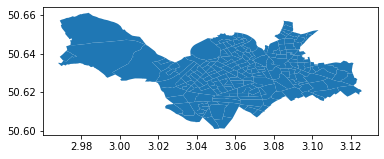

In [23]:
section_test_nord[section_test_nord["commune"] == "59350"].plot()

La section semble être une échelle assez fine. Il faudrait voir ce que Filosofi propose.

## Utilisation de la table lomut_mai_apt_polycal_geomloc + bonne geo

Lecture de la table local_geomloc puis changement du type de projection de Lambert 92 à WGS 84

In [219]:
local_geomloc = gpd.read_file(dossier_donnees + "r32_local_geomloc.shp")
local_geomloc_wgs = local_geomloc.to_crs({'init' :'epsg:4326'}) 
local_geomloc_wgs  = local_geomloc_wgs.rename(columns = {"IDMUTATION" : "idmutation"})

C:\Users\khale\anaconda3\envs\projet_2A\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [213]:
mutation_brute = pd.read_csv(dossier_donnees + "r32_mutation.csv")
mutation_vente = mutation_brute[mutation_brute["idnatmut"].isin(range(2))].reset_index()
reg_maison_appar = re.compile(".*(MAISON|APPARTEMENT).*")
mutation_vente_mai_apt = mutation_vente[mutation_vente["libtypbien"].str.match(reg_maison_appar)]

Attention : dans la table *mutation*, certaines colonnes sont formées par des *sets* : il n'est pas possible de tester directement. Il faut donc transformer ces set en string.

In [215]:
code_poste = re.compile("\d{5}")
mutation_vente_mai_apt["codinsee"] = mutation_vente_mai_apt["l_codinsee"].apply(lambda x: " ".join(re.findall(code_poste,str(x))))

<ipython-input-215-75051c17f017>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mutation_vente_mai_apt["codinsee"] = mutation_vente_mai_apt["l_codinsee"].apply(lambda x: " ".join(re.findall(code_poste,str(x))))


In [220]:
mut_mai_apt_poly = mutation_vente_mai_apt.merge(local_geomloc_wgs, on = "idmutation", how = "inner")

Création d'une colonne département à l'aide du COG de la commune où se situe la parcelle

In [221]:
mut_mai_apt_poly["dep"] = mut_mai_apt_poly["codinsee"].str[:2]

<AxesSubplot:>

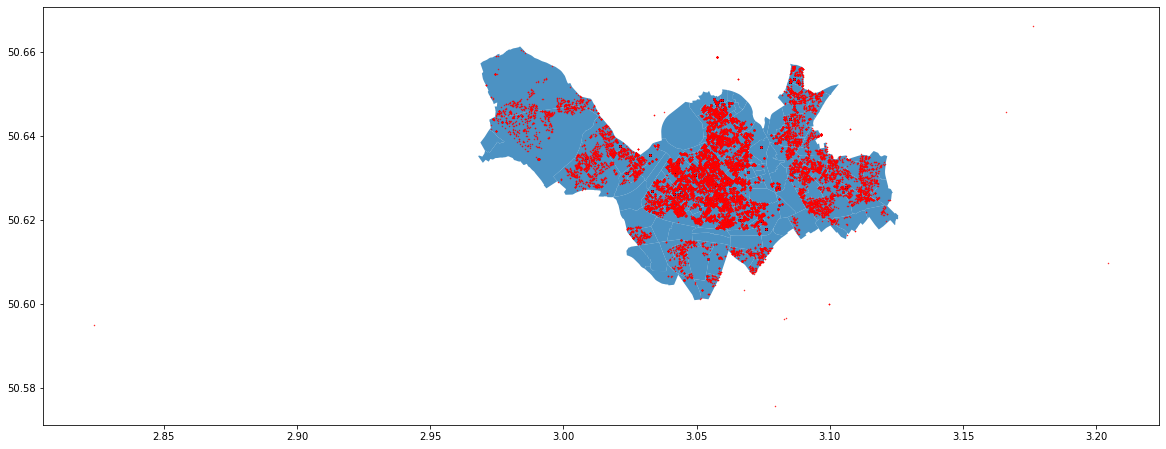

In [251]:
ax = section_test_nord[section_test_nord["commune"] == "59350"].plot(alpha = 0.8, figsize=(20, 20))
gpd.GeoDataFrame(mut_mai_apt_poly[mut_mai_apt_poly["codinsee"].str.contains("59350")][["idmutation","geometry"]]).plot(markersize = 0.2, color = "red", ax = ax)

In [290]:
def polygon_into_coord(polygon):
    x,y = polygon.coords.xy
    return (x[0],y[0])

In [296]:
len(local_geomloc_wgs["idmutation"].drop_duplicates())

442992